✞ *For the protection of wisdom is like the protection of money, and the advantage of knowledge is that wisdom preserves the life of him who has it.* ✞

#### Imports

In [1]:
import timeit
start_time = timeit.default_timer()


In [2]:
import pandas as pd
if CUDF:
    import cudf as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# from cairosvg import svg2png
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from scipy.ndimage.interpolation import shift
# from sklearn.metrics import roc_auc_score
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

KAGGLE = 0
print('Import packages')

Import packages


In [3]:
# RIIID env init
if KAGGLE:
    import riiideducation

    env = riiideducation.make_env()

#### Global Variables

In [4]:
print('global variables')
TRAIN_CSV_PATH = 'train.feather'
QUESTIONS_CSV_PATH = 'questions.csv'
LECTURES_CSV_PATH = 'lectures.csv'
SAMPLE_CSV_PATH = 'example_sample_submission.csv'
SAMPLE_TEST_CSV_PATH = 'example_test.csv'

if KAGGLE:
    TRAIN_CSV_PATH = '../input/myriiddataset/train.feather'
    QUESTIONS_CSV_PATH = '../input/myriiddataset/questions.feather'
    LECTURES_CSV_PATH = '../input/myriiddataset/lectures.feather'
    SAMPLE_TEST_CSV_PATH = '../input/riiid-test-answer-prediction/example_test.csv'

COLUMN_TYPES = {
    'row_id': 'int64',
    'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int16',
    'content_type_id': 'int8',
    'task_container_id': 'int16',
    'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32',
    'prior_question_had_explanation': 'bool'
}

global variables


In [5]:
# train_df = pd.read_csv(TRAIN_CSV_PATH, nrows=10**5, dtype=COLUMN_TYPES)
train_df = pd.read_feather(TRAIN_CSV_PATH)
target_df = train_df[90000000:92500000]
train_df = train_df.iloc[:2 * (10 ** 6)]
if KAGGLE:
    questions_df = pd.read_feather(QUESTIONS_CSV_PATH)
    lectures_df = pd.read_feather(LECTURES_CSV_PATH)
else:
    questions_df = pd.read_csv(QUESTIONS_CSV_PATH)
    lectures_df = pd.read_csv(LECTURES_CSV_PATH)
    sample_test_df = pd.read_csv(SAMPLE_TEST_CSV_PATH)

### Common Variables

In [6]:
# The question based information dict
# NOTE: generated only after we move to the training data
individual_question_min_time_dict = {}
individual_question_mean_time_dict = {}
average_question_timestamp_difference_dict = {}
bundle_time_relation_dict = {}

# check average user answering time
user_average_time_to_elapsed_dict = train_df[['user_id', 'prior_question_elapsed_time']].groupby("user_id").prior_question_elapsed_time.mean().to_dict()
# check average question answering time
average_question_prior_question_elapsed_time_dict = train_df[['content_id', 'prior_question_elapsed_time']].groupby(["content_id"]).prior_question_elapsed_time.mean().to_dict()
# The correct answered questions
check_answered_correctly = (train_df.answered_correctly == 1)
question_rows = (train_df.content_type_id == 0)

print('common variables')

common variables


### Check for question specific features

In [8]:
questions_df.tags.fillna("118", inplace=True)
tag_counts_agg = questions_df[['tags', 'question_id']].groupby('tags')['tags'].count()
tag_counts_list = list(tag_counts_agg.sort_values().index.values)
questions_df['tag_count_wise_id'] = questions_df.apply(lambda row: tag_counts_list.index(row.tags), axis=1)

In [9]:
# Find the wrong and right question tags based on correctly answered
tags_list = [value.split() for value in questions_df.tags.values]

questions_df['tags_list'] = tags_list
questions_df['number_of_tags'] = questions_df.apply(lambda row: len(row.tags), axis=1)
questions_df['tags'] = questions_df['tags'].astype(str)

questions_df.head()

,question_id,bundle_id,correct_answer,part,tags,tag_count_wise_id,tags_list,number_of_tags
0,0,0,0,1,51 131 162 38,1055,"[51, 131, 162, 38]",13
1,1,1,1,1,131 36 81,963,"[131, 36, 81]",9
2,2,2,0,1,131 101 162 92,574,"[131, 101, 162, 92]",14
3,3,3,0,1,131 149 162 29,651,"[131, 149, 162, 29]",14
4,4,4,3,1,131 5 162 38,910,"[131, 5, 162, 38]",12


In [10]:
# The part content type of the question wheather if it is a listening section or a reading secition
questions_df['part_test_listening'] = True
reading_sections_parts = [5, 6, 7]
questions_df.loc[questions_df.part.isin(reading_sections_parts), 'part_test_listening'] = False
questions_df.part_test_listening.unique()

array([ True, False])

In [11]:
# get all the complete tags of the question
tags = [value.split() for value in questions_df[questions_df.tags != "nan"].tags.values]
tags = [item for elem in tags for item in elem]
tags = set(tags)
tags = list(tags)

In [12]:
# Question dict
question_dict = questions_df[['question_id', 'tags', 'part', 'bundle_id', 'tags_list']].set_index('question_id').to_dict(orient='index')

In [13]:
questions_df[questions_df['question_id'] == 5692]

,question_id,bundle_id,correct_answer,part,tags,tag_count_wise_id,tags_list,number_of_tags,part_test_listening
5692,5692,5692,3,5,151,1364,[151],3,False


In [14]:
# Find the wrong and right question based on correctly answered
correct = train_df.loc[question_rows, ['content_id', 'answered_correctly']].groupby(['content_id', 'answered_correctly'], as_index=False).size()
correct = correct.pivot(index= 'content_id', columns='answered_correctly', values='size')
correct.columns = ['wrong', 'right']
correct = correct.fillna(0)
correct[['wrong', 'right']] = correct[['wrong', 'right']].astype(int)
questions_df = questions_df.merge(correct, left_on = 'question_id', right_on = 'content_id', how = 'left')
questions_df['percentage_correct'] = questions_df.right / (questions_df.right + questions_df.wrong)
questions_df.head()

# questions_df.drop(['wrong_x', 'right_x', 'wrong_y', 'right_y'], axis=1, inplace=True)

,question_id,bundle_id,correct_answer,part,tags,tag_count_wise_id,tags_list,number_of_tags,part_test_listening,wrong,right,percentage_correct
0,0,0,0,1,51 131 162 38,1055,"[51, 131, 162, 38]",13,True,16.0000,136.0000,0.8947
1,1,1,1,1,131 36 81,963,"[131, 36, 81]",9,True,11.0000,139.0000,0.9267
2,2,2,0,1,131 101 162 92,574,"[131, 101, 162, 92]",14,True,410.0000,509.0000,0.5539
3,3,3,0,1,131 149 162 29,651,"[131, 149, 162, 29]",14,True,90.0000,348.0000,0.7945
4,4,4,3,1,131 5 162 38,910,"[131, 5, 162, 38]",12,True,233.0000,417.0000,0.6415


In [15]:
# TODO: This seems to be wrong please check again
train_df.loc[question_rows, ['question_bundle_id']] = train_df.loc[question_rows, ['content_id']].apply(lambda row: question_dict[row.content_id].get('bundle_id'), axis=1)
correct = train_df.loc[question_rows, ['question_bundle_id', 'answered_correctly']].groupby(["question_bundle_id", 'answered_correctly'], as_index=False).size()
correct = correct.pivot(index= "question_bundle_id", columns='answered_correctly', values='size')
correct.columns = ['bundle_wrong', 'bundle_right']
correct = correct.fillna(0)
correct[['bundle_wrong', 'bundle_right']] = correct[['bundle_wrong', 'bundle_right']].astype(int)

questions_df = questions_df.merge(correct, left_on = "bundle_id", right_on = "question_bundle_id", how = "left")
questions_df['task_percentage_correct'] = questions_df.bundle_right / (questions_df.bundle_right + questions_df.bundle_wrong)
questions_df.head()

,question_id,bundle_id,correct_answer,part,tags,tag_count_wise_id,tags_list,number_of_tags,part_test_listening,wrong,right,percentage_correct,bundle_wrong,bundle_right,task_percentage_correct
0,0,0,0,1,51 131 162 38,1055,"[51, 131, 162, 38]",13,True,16.0000,136.0000,0.8947,16.0000,136.0000,0.8947
1,1,1,1,1,131 36 81,963,"[131, 36, 81]",9,True,11.0000,139.0000,0.9267,11.0000,139.0000,0.9267
2,2,2,0,1,131 101 162 92,574,"[131, 101, 162, 92]",14,True,410.0000,509.0000,0.5539,410.0000,509.0000,0.5539
3,3,3,0,1,131 149 162 29,651,"[131, 149, 162, 29]",14,True,90.0000,348.0000,0.7945,90.0000,348.0000,0.7945
4,4,4,3,1,131 5 162 38,910,"[131, 5, 162, 38]",12,True,233.0000,417.0000,0.6415,233.0000,417.0000,0.6415


In [16]:
tags_df = pd.DataFrame()
for x in range(len(tags)):
    df = questions_df[questions_df.tags.apply(lambda l: tags[x] in l)]
    df1 = df.agg({'wrong': ['sum'], 'right': ['sum']})
    df1['total_questions'] = df1.wrong + df1.right
    df1['question_ids_with_tag'] = len(df)
    df1['tag'] = tags[x]
    df1 = df1.set_index('tag')
    tags_df = tags_df.append(df1)

tags_df[['wrong', 'right', 'total_questions']] = tags_df[['wrong', 'right', 'total_questions']].astype(int)
tags_df['percent_correct'] = tags_df.right / tags_df.total_questions
tags_df = tags_df.sort_values(by = "percent_correct")

tags_df_dict = tags_df.to_dict(orient='index')
tags_df.head()

,wrong,right,total_questions,question_ids_with_tag,percent_correct
tag,,,,,
24,5070,4796,9866,29,0.4861
151,5345,5078,10423,16,0.4872
23,10414,10492,20906,40,0.5019
167,3276,3369,6645,11,0.5070
108,4489,4656,9145,20,0.5091


In [17]:
question_dict = questions_df[['question_id', 'percentage_correct', 'tags', 'part', 'bundle_id', 'tags_list']].set_index('question_id').to_dict(orient='index')

print('question specific functions')


question specific functions


### The lecture specific data creation

In [18]:
# The lecture based dict for type of and part
lecture_dict = lectures_df.set_index("lecture_id").to_dict(orient="index")
lecture_comprehensive_type_of_dict = lectures_df.set_index('type_of').groupby(level=0).apply(lambda row: row.to_dict('list')).to_dict()
lecture_comprehensive_part_dict = lectures_df.set_index('part').groupby(level=0).apply(lambda row: row.to_dict('list')).to_dict()

In [19]:
for key in lecture_comprehensive_part_dict:
    lecture_comprehensive_part_dict[key]['tag'] = list(set(lecture_comprehensive_part_dict[key]['tag']))
    lecture_comprehensive_part_dict[key]['type_of'] = list(set(lecture_comprehensive_part_dict[key]['type_of']))

for key in lecture_comprehensive_type_of_dict:
    lecture_comprehensive_type_of_dict[key]['tag'] = list(set(lecture_comprehensive_type_of_dict[key]['tag']))
    lecture_comprehensive_type_of_dict[key]['part'] = list(set(lecture_comprehensive_type_of_dict[key]['part']))

print('lecture specific')

lecture specific


### Common function

In [20]:
def convert_timestamp_in_parts(millis):
    seconds = (millis / 1000)
    minutes = (seconds / 60)
    hours = (minutes / 60)
    days = (hours / 24)
    return days, hours, minutes, seconds

def get_timestamp_in_parts(row):
    millis = row.timestamp
    seconds = (millis / 1000)
    minutes = (seconds / 60)
    hours = (minutes / 60)
    days = (hours / 24)
    return days, hours

def get_prior_elasped_time_in_parts(row):
    prior_millis = row.prior_question_elapsed_time
    prior_seconds = (prior_millis / 1000)
    prior_minutes = (prior_seconds / 60)
    return prior_minutes

In [21]:
# Retention
# https://en.wikipedia.org/wiki/Forgetting_curve
# https://psychology.stackexchange.com/questions/5199/which-equation-is-ebbinghauss-forgetting-curve-and-what-do-the-constants-repres
def apply_filter_based_on_previous_row(func):
    prev_row = {
        "has_seen_lecture": False,
        "previous_lecture_hours": 0,
        "previous_lecture": {},
        "user_id": ""
    }
    def wrapper(curr_row, **kwargs):
        content_id = curr_row.content_id
        tag_of_prev_lecture = 0
        part_of_prev_lecture = 0
        has_seen_same_tag_as_lecture = False
        has_seen_same_part_as_lecture = False
        has_part_common_with_type_of = False
        has_tag_common_with_type_of = False
        has_tag_common_with_part_dict = False
        has_type_of_common_with_part_dict = False
        event_in_hours = get_timestamp_in_parts(curr_row)[1]
        if prev_row['user_id'] == curr_row.user_id:
            if curr_row.content_type_id != 0:
                prev_row['has_seen_lecture'] = True
                prev_row['previous_lecture_hours'] = event_in_hours
                prev_row['previous_lecture'] = lecture_dict[content_id]
            else:
                has_seen_same_tag_as_lecture = (str(prev_row['previous_lecture'].get("tag", "")) in str(question_dict[content_id]['tags']).split())
                has_seen_same_part_as_lecture = (prev_row['previous_lecture'].get("part") == question_dict[content_id]['part'])
                prev_type_of = prev_row['previous_lecture'].get("type_of")
                prev_part = prev_row['previous_lecture'].get("part")
                has_part_common_with_type_of = question_dict[content_id]['part'] in  lecture_comprehensive_type_of_dict.get(prev_type_of, {}).get('part', [])
                has_tag_common_with_type_of = bool(set(map(int, str(question_dict[content_id]['tags']).split())).intersection(lecture_comprehensive_type_of_dict.get(prev_type_of, {}).get('tag', [])))
                has_tag_common_with_part_dict = bool(set(map(int, str(question_dict[content_id]['tags']).split())).intersection(lecture_comprehensive_part_dict.get(prev_part, {}).get('tag', [])))
                has_type_of_common_with_part_dict = prev_type_of in lecture_comprehensive_part_dict[question_dict[content_id]['part']]['type_of']
                tag_of_prev_lecture = prev_row['previous_lecture'].get('tag', 0)
                part_of_prev_lecture = prev_row['previous_lecture'].get('part', 0)
        else:
            prev_row['user_id'] = curr_row.user_id
            if curr_row.content_type_id != 0:
                prev_row['has_seen_lecture'] = True
                prev_row['previous_lecture_hours'] = event_in_hours
                prev_row['previous_lecture'] = lecture_dict[content_id]
            else:
                prev_row['has_seen_lecture'] = False
                prev_row['previous_lecture_hours'] = 0
                prev_row['previous_lecture'] = {}

        timestamp_difference = event_in_hours - prev_row['previous_lecture_hours']
        retention = func(timestamp_difference)
        return retention, tag_of_prev_lecture, part_of_prev_lecture, prev_row['has_seen_lecture'], has_seen_same_tag_as_lecture, has_seen_same_part_as_lecture, has_part_common_with_type_of, has_tag_common_with_type_of, has_tag_common_with_part_dict, has_type_of_common_with_part_dict

    return wrapper

@apply_filter_based_on_previous_row
def running_retention(timestamp_difference):
    retention = 1.48 / ((1.25 * timestamp_difference) + 1.48)
    return retention

In [23]:
def get_shift_values(df, groupby=True):
    if groupby:
        user_group_by = df[['user_id', 'timestamp', 'prior_question_elapsed_time', 'prior_question_had_explanation']].groupby('user_id')
    else:
        user_group_by = df
    event_time = user_group_by['timestamp'].diff()
    shift_event_time = shift(event_time, -1, cval=np.NaN)
    shift_elapsed_time = user_group_by.prior_question_elapsed_time.shift(-1)
    shift_prior_question_had_explanation = user_group_by.prior_question_had_explanation.shift(-1)

    event_lag_time = shift_event_time - shift_elapsed_time
    return event_time.values, shift_event_time, shift_elapsed_time.values, shift_prior_question_had_explanation.values, event_lag_time.values

def get_prior_elapsed_time_difference(content_id, shift_elapsed_time):
    question_min_time = individual_question_min_time_dict.get(content_id, shift_elapsed_time)
    return shift_elapsed_time - question_min_time

In [24]:
# function to check based on the average time taken for question
def has_elapsed_time_greater_than_average_time(content_id, shift_elapsed_time):
    question_min_time = individual_question_mean_time_dict.get(content_id, shift_elapsed_time)
    return shift_elapsed_time > question_min_time

def has_event_time_greater_than_average(content_id, event_time):
    average_question_time = average_question_timestamp_difference_dict.get(content_id, event_time)
    return event_time > average_question_time

In [25]:
# TODO: Too heavy function
# Question time list
bundle_time_relation_dict = {}
prev_row = {
    "user_id": "",
    "bundle_id": "",
    "previous_bundle_elapsed_time": ""
}


def get_question_time_taken(curr_row):
    current_bundle_id = question_dict[curr_row.content_id]['bundle_id']
    if prev_row['user_id'] == curr_row.user_id:
        if prev_row['bundle_id'] == current_bundle_id:
            time_taken_for_question = prev_row['previous_bundle_elapsed_time']
        else:
            time_taken_for_question = curr_row.prior_question_elapsed_time
            prev_row['previous_bundle_elapsed_time'] = curr_row.prior_question_elapsed_time
            prev_row['bundle_id'] = current_bundle_id
    else:
        prev_row['bundle_id'] = current_bundle_id
        prev_row['previous_bundle_elapsed_time'] = curr_row.prior_question_elapsed_time
        time_taken_for_question = 0
    prev_row['user_id'] = curr_row.user_id
    return time_taken_for_question


for index, row in train_df.loc[question_rows, ['timestamp', 'content_id', 'user_id', 'prior_question_elapsed_time']].iloc[::-1].iterrows():
    if row.content_id in bundle_time_relation_dict and bundle_time_relation_dict:
        bundle_time_relation_dict[row.content_id]['question_time_list'].append(get_question_time_taken(row))
    else:
        bundle_time_relation_dict[row.content_id] = {
            "question_time_list": [get_question_time_taken(row)]
        }

for content_id in bundle_time_relation_dict.keys():
    bundle_time_relation_dict[content_id]['minimum_time'] = min(bundle_time_relation_dict[content_id]['question_time_list'])
    bundle_time_relation_dict[content_id]['average_time'] = np.mean(bundle_time_relation_dict[content_id]['question_time_list'])

In [26]:
def get_bundle_lag_time(row):
    minmum_time = bundle_time_relation_dict.get(row.content_id, {'minimum_time': 0})['minimum_time']
    if row.shift_elapsed_time > minmum_time:
        return row.shift_elapsed_time - minmum_time
    return 0

In [27]:
# TODO: please check the values that is used in each question they might be wrong
def is_question_above_average_answering(row):
    percentage_correct = question_dict[row.content_id].get('percentage_correct')
    if percentage_correct:
        return percentage_correct > 50
    return False

def is_all_tags_above_average_answering(row):
    tags_answer_percentages = []
    tags = question_dict[row.content_id].get('tags_list')
    if not tags:
        return False

    for tag in tags:
        tags_answer_percentages.append(tags_df_dict.get(tag, {'percent_correct': 0})['percent_correct'])
    overall_tag_percentage = sum(tags_answer_percentages) / len(tags)
    return overall_tag_percentage > 0.5

In [28]:
def get_sum_std_correctness(df, group_by_feature, target):
    feature_agg = df[[group_by_feature, target]].groupby(group_by_feature)[target].agg(['sum', 'count','var'])
    feature_agg = feature_agg.astype('float32')

    df = df.replace([np.inf, -np.inf], np.nan)
    feature_sum = df[group_by_feature].map(feature_agg['sum']).fillna(0).astype('int32')
    feature_std = df[group_by_feature].map(feature_agg['var']).fillna(0).astype('float16')
    feature_correctness = df[group_by_feature].map(feature_agg['sum'] / feature_agg['count'])

    feature_correctness = feature_correctness.astype('float16')
    return feature_sum.values, feature_std.values, feature_correctness.values

def get_sum_std_correctness_agg_dict(df, group_by_feature, target):
    feature_agg = df[[group_by_feature, target]].groupby(group_by_feature)[target].agg(['sum', 'count','var'])
    feature_agg = feature_agg.astype('float32')

    feature_sum_dict = (feature_agg['sum']).fillna(0).astype('int32').to_dict()
    feature_var_dict = (feature_agg['var']).fillna(0).astype('float16').to_dict()
    feature_count_dict = (feature_agg['count']).fillna(0).astype('float16').to_dict()
    feature_correctness = (feature_agg['sum'] / feature_agg['count'])
    feature_correctness = feature_correctness.astype('float16')
    feature_correctness_dict = feature_correctness.to_dict()

    return feature_sum_dict, feature_var_dict, feature_count_dict, feature_correctness_dict

def get_cum_sum_std_correctness(df, group_by_feature, target):
    cum = df[[group_by_feature, target]].groupby(group_by_feature)[target].agg(['cumsum', 'cumcount'])
    feature_cum_correctness = cum['cumsum'] / cum['cumcount']
    feature_correct_cumsum = cum['cumsum'].fillna(0)
    feature_correct_cumcount = cum['cumcount'].fillna(0)

    feature_cum_correctness = feature_cum_correctness.astype('float16')
    feature_correct_cumcount = feature_correct_cumcount.astype('int16')
    feature_correct_cumsum = feature_correct_cumsum.astype('int16')
    return feature_cum_correctness.values, feature_correct_cumcount.values, feature_correct_cumsum.values

def get_cum_sum_std_correctness_dict(df, group_by_feature, target):
    cum = df[[group_by_feature, target]].groupby(group_by_feature)[target].agg(['cumsum', 'cumcount'])
    feature_cum_correctness = cum['cumsum'] / cum['cumcount']
    feature_cum_correctness = feature_cum_correctness.astype('float16')
 
    feature_correct_cumsum = cum['cumsum'].fillna(0).astype('int16')
    feature_correct_cumcount = cum['cumcount'].fillna(0).astype('int16')

    feature_cum_correctness_dict = feature_cum_correctness.to_dict()
    feature_correct_cumsum_dict = feature_correct_cumsum.to_dict()
    feature_correct_cumcount_dict = feature_correct_cumcount.to_dict()

    return feature_cum_correctness_dict, feature_correct_cumsum_dict, feature_correct_cumcount_dict

print('common functions')

common functions


### Prepare first group test set with train_df

### Set User specific features

In [29]:
train_df.sort_values(['user_id', 'timestamp'], inplace=True)

In [ ]:
# Join question df
train_df = train_df.join(questions_df.set_index("question_id"), 'content_id', how='left')

In [ ]:
# The common aggregate dicts
required_columns = ['user_id', 'answered_correctly']
user_cum_correctness_dict, user_correct_cumsum_dict, user_correct_cumcount_dict = get_cum_sum_std_correctness_dict(train_df[required_columns], required_columns[0], required_columns[1])

required_columns = ['user_id', 'has_seen_question_explanation']
has_seen_ques_cum_correctness_dict, has_seen_ques_correct_cumsum_dict, has_seen_ques_correct_cumcount_dict = get_cum_sum_std_correctness_dict(train_df[required_columns], required_columns[0], required_columns[1])

required_columns = ['user_id', 'answered_correctly']
user_sum_dict, user_var_dict, user_count_dict, user_correctness_dict = get_sum_std_correctness_agg_dict(train_df[required_columns], required_columns[0], required_columns[1])

required_columns = ['content_id', 'answered_correctly']
content_sum_dict, content_var_dict, content_count_dict, content_correctness_dict = get_sum_std_correctness_agg_dict(train_df[required_columns], required_columns[0], required_columns[1])

required_columns = ['bundle_id', 'answered_correctly']
bundle_sum_dict, bundle_var_dict, bundle_count_dict, bundle_correctness_dict = get_sum_std_correctness_agg_dict(train_df[required_columns], required_columns[0], required_columns[1])

required_columns = ['part', 'answered_correctly']
part_sum_dict, part_var_dict, part_count_dict, part_correctness_dict = get_sum_std_correctness_agg_dict(train_df[required_columns], required_columns[0], required_columns[1])

required_columns = ['part_test_listening', 'answered_correctly']
part_test_listening_sum_dict, part_test_listening_var_dict, part_test_listening_count_dict, part_test_listening_correctness_dict = get_sum_std_correctness_agg_dict(train_df[required_columns], required_columns[0], required_columns[1])


In [ ]:
train_users_questions_only_filter = (train_df['content_type_id'] == 0)
check_answered_correctly_filter = (train_df['answered_correctly'] == 1)

In [ ]:

# ##### 4. Now lets find out the lag time
group_by_required_fields = ['user_id', 'timestamp', 'prior_question_elapsed_time', 'prior_question_had_explanation']
train_users_grouped_by_df = train_users_df.loc[train_users_questions_only_filter, group_by_required_fields].groupby('user_id')

group_by_answered_correctly_fields = ['shift_elapsed_time', 'user_id', 'event_time', 'shift_event_time']
train_users_answered_correctly_grouped_by_df = train_users_df.loc[check_answered_correctly_filter, group_by_answered_correctly_fields].groupby('user_id')

content_id_group_by_required_fields = ['prior_question_elapsed_time', 'content_id']
train_content_grouped_by_df = train_users_df.loc[train_users_questions_only_filter, content_id_group_by_required_fields].groupby(["content_id"])

train_users_df.loc[train_users_questions_only_filter, ['event_time', 'shift_event_time', 'shift_elapsed_time', 'has_seen_question_explanation', 'event_lag_time']] = list(zip(*get_shift_values(train_users_grouped_by_df, groupby=False)))
train_users_df.has_seen_question_explanation = train_users_df.has_seen_question_explanation.fillna(False).astype(np.bool)

# check average user answering time
# check average question answering time
user_average_time_to_elapsed_dict = train_users_grouped_by_df.prior_question_elapsed_time.mean().to_dict()
average_question_prior_question_elapsed_time_dict = train_content_grouped_by_df.prior_question_elapsed_time.mean().to_dict()

elapsed_time_mean_dict = train_users_answered_correctly_grouped_by_df.shift_elapsed_time.mean().to_dict()
event_time_mean_dict = train_users_answered_correctly_grouped_by_df.event_time.mean().to_dict()
shift_event_time_mean_dict = train_users_answered_correctly_grouped_by_df.shift_event_time.mean().to_dict()

user_lecture_history_dict = {}
# the above one will be like follows
# {
#     "user_id": {
#         "lecture_id": {
#             "last_timestamp": 0,
#             "timestamp_list": [],
#             "part": "",
#             "tag": "" 
#         }
#     }
# }

##### 1. Get timestamp as hours and minutes

In [ ]:
feature_generating_rows = [
    "timestamp",
    "user_id",
    "content_id",
    "content_type_id",
    "task_container_id",
    "prior_question_elapsed_time",
    "prior_question_had_explanation",
    "shift_elapsed_time",
    "shift_event_time",
    "event_time",
    "bundle_id",
    "part",
    "part_test_listening"
]

In [ ]:

def get_retention(timestamp_difference):
    retention = 1.48 / ((1.25 * timestamp_difference) + 1.48)
    return retention

def store_user_lecture_details(row):
    user_id = row.user_id
    content_id = row.content_id
    timestamp = row.timestamp
    lecture_details = lecture_dict[content_id]

    if user_id in user_lecture_history_dict:
        if content_id in user_lecture_history_dict[user_id]:
            user_lecture_history_dict[user_id][content_id]['timestamp'] = timestamp
            user_lecture_history_dict[user_id][content_id]['part'] = lecture_details['part']
            user_lecture_history_dict[user_id][content_id]['tag'] = lecture_details['tag']
            user_lecture_history_dict[user_id][content_id]['type_of'] = lecture_details['type_of']
            user_lecture_history_dict[user_id][content_id]['timestamp_list'].append(timestamp)

            user_lecture_history_dict[user_id]["last_value"]['timestamp'] = timestamp
            user_lecture_history_dict[user_id]["last_value"]['part'] = lecture_details['part']
            user_lecture_history_dict[user_id]["last_value"]['tag'] = lecture_details['tag']
            user_lecture_history_dict[user_id]["last_value"]['timestamp_list'].append(timestamp)
            user_lecture_history_dict[user_id]["last_value"]['part_list'].append(lecture_details['part'])
            user_lecture_history_dict[user_id]["last_value"]['tag_list'].append(lecture_details['tag'])
            user_lecture_history_dict[user_id]["last_value"]['type_of'].append(lecture_details['type_of'])
        else:
            user_lecture_history_dict[user_id][content_id] = {
                "timestamp": timestamp,
                "timestamp_list": [timestamp],
                "part": lecture_details['part'],
                "tag": lecture_details['tag'],
                "type_of": lecture_details['type_of']
            }
            user_lecture_history_dict[user_id]["last_value"]['timestamp'] = timestamp
            user_lecture_history_dict[user_id]["last_value"]['part'] = lecture_details['part']
            user_lecture_history_dict[user_id]["last_value"]['tag'] = lecture_details['tag']
            user_lecture_history_dict[user_id]["last_value"]['type_of'] = lecture_details['type_of']
            user_lecture_history_dict[user_id]["last_value"]['timestamp_list'].append(timestamp)
            user_lecture_history_dict[user_id]["last_value"]['part_list'].append(lecture_details['part'])
            user_lecture_history_dict[user_id]["last_value"]['tag_list'].append(lecture_details['tag'])
            user_lecture_history_dict[user_id]["last_value"]['type_of'].append(lecture_details['type_of'])
    else:
        user_lecture_history_dict[user_id] = {
            content_id: {
                "timestamp": timestamp,
                "timestamp_list": [timestamp],
                "part": lecture_details['part'],
                "tag": lecture_details['tag'],
                "type_of": lecture_details['type_of']
            },
            "last_value": {
                "timestamp": timestamp,
                "timestamp_list": [timestamp],
                "part": lecture_details['part'],
                "part_list": [lecture_details['part']],
                "tag": lecture_details['tag'],
                "tag_list": [lecture_details['tag']],
                "type_of": [lecture_details['type_of']]
            }
        }
    return lecture_details['part'], lecture_details['type_of']

def get_user_lecture_features(row):
    user_id = row.user_id
    content_id = row.content_id
    tag_of_prev_lecture = None
    part_of_prev_lecture = None
    has_seen_same_tag_as_lecture = False
    has_seen_same_part_as_lecture = False
    has_part_common_with_type_of = False
    has_tag_common_with_type_of = False
    has_tag_common_with_part_dict = False
    has_type_of_common_with_part_dict = False
    has_seen_lecture = True
    event_in_hours = get_timestamp_in_parts(row)[1]
    retention = 0

    if user_id in user_lecture_history_dict:
        has_seen_lecture = True

        lecture_details = user_lecture_history_dict[user_id]['last_value']
        prev_type_of = lecture_details['type_of']
        prev_part = lecture_details['part']
        prev_tag = lecture_details['tag']
        prev_timestamp = lecture_details['timestamp']
        prev_hours = convert_timestamp_in_parts(prev_timestamp)[1]
        question_tags = eval(question_dict[content_id]['tag_list'])
        question_part = question_dict[content_id]['part']
        has_seen_same_tag_as_lecture = lecture_details['tag'] in question_tags
        has_seen_same_part_as_lecture = lecture_details['part'] == question_part
    
        has_part_common_with_type_of = question_part in lecture_comprehensive_type_of_dict.get(prev_type_of, {}).get('part', [])
        has_tag_common_with_type_of = bool(set(question_tags).intersection(lecture_comprehensive_type_of_dict.get(prev_type_of, {}).get('tag', [])))
        has_tag_common_with_part_dict = bool(set(question_tags).intersection(lecture_comprehensive_part_dict.get(prev_part, {}).get('tag', [])))
        has_type_of_common_with_part_dict = prev_type_of in lecture_comprehensive_part_dict[question_part]['type_of']
        tag_of_prev_lecture = prev_part
        part_of_prev_lecture = prev_tag
        timestamp_difference = event_in_hours - prev_hours
        retention = get_retention(timestamp_difference)
    
    return retention, tag_of_prev_lecture, part_of_prev_lecture, prev_row['has_seen_lecture'], has_seen_same_tag_as_lecture, has_seen_same_part_as_lecture, has_part_common_with_type_of, has_tag_common_with_type_of, has_tag_common_with_part_dict, has_type_of_common_with_part_dict

In [ ]:
event_in_days = []
event_in_hours = []
prior_minutes = []
intro_sections = []
retention = []
previous_lecture_tag = []
previous_lecture_part = []
has_seen_lecture_before = []
has_seen_same_tag_as_lecture = []
has_seen_same_part_as_lecture = []
has_part_common_with_type_of = []
has_tag_common_with_type_of = []
has_tag_common_with_part_dict = []
has_type_of_common_with_part_dict = []
lag_time = []
bundle_lag_time = []
question_answered_late = []
event_time_greater_than_average = []
question_took_less_than_average_user_time = []
question_took_less_than_average_content_time = []
has_less_than_average_bundle_time = []
question_has_above_average_correctness = []
tag_has_above_average_correctness = []
has_above_average_lag_time_for_the_question = []
has_above_average_shift_elpased_time_for_the_question = []
has_above_user_average_time_to_answer = []
has_above_user_average_time_for_event = []
has_above_user_average_time_for_shift_event = []

user_cum_correctness = []
user_correct_cumsum = []
user_correct_cumcount = []

seen_question_explanation_mean = []
seen_question_explanation_cumsum = []
seen_question_explanation_cumcount = []

user_correct_sum = []
user_correct_std = []
user_correctness = []

content_sum = []
content_std = []
content_correctness = []
bundle_sum = []
bundle_std = []
bundle_correctness = []
part_sum = []
part_std = []
part_correctness = []
part_test_listening_sum = []
part_test_listening_std = []
part_test_listening_correctness = []

part1_lecture = []
part2_lecture = []
part3_lecture = []
part4_lecture = []
part5_lecture = []
part6_lecture = []
part7_lecture = []

part_values = {
    "part1": False,
    "part2": False,
    "part3": False,
    "part4": False,
    "part5": False,
    "part6": False,
    "part7": False
}


type_of_concept = []
type_of_intention = []
type_of_solving_question = []
type_of_starter = []

type_of_values = {
    "type_of_concept": False,
    "type_of_intention": False,
    "type_of_solving_question": False,
    "type_of_starter": False,
}

tag1_question = []
tag2_question = []
tag3_question = []
tag4_question = []
tag5_question = []

hmean_user_content_accuracy = []
for row in train_df[feature_generating_rows].itertuples():
    tag_question_values = {
        "tag1": "",
        "tag2": "",
        "tag3": "",
        "tag4": "",
        "tag5": "",
    }
    # ##### 1. Get timestamp as hours and minutes
    event_time_split = get_timestamp_in_parts(row)
    event_in_days.append(event_time_split[0])
    event_in_hours.append(event_time_split[1])

    prior_minutes.append(get_prior_elasped_time_in_parts(row))

    # ##### 2. Find the intro rows.
    if row.timestamp == 0 or row.task_container_id == 0 or row.content_id in intro_section_values:
        intro_sections.append(True)
    else:
        intro_sections.append(False)


    if row.content_type_id == 0:

        time_related_feature_values = get_user_lecture_features(row)
        retention.append(time_related_feature_values[0])
        previous_lecture_tag.append(time_related_feature_values[1])
        previous_lecture_part.append(time_related_feature_values[2])
        has_seen_lecture_before.append(time_related_feature_values[3])
        has_seen_same_tag_as_lecture.append(time_related_feature_values[4])
        has_seen_same_part_as_lecture.append(time_related_feature_values[5])
        has_part_common_with_type_of.append(time_related_feature_values[6])
        has_tag_common_with_type_of.append(time_related_feature_values[7])
        has_tag_common_with_part_dict.append(time_related_feature_values[8])
        has_type_of_common_with_part_dict.append(time_related_feature_values[9])

        part1_lecture.append(part_values["part1"])
        part2_lecture.append(part_values["part2"])
        part3_lecture.append(part_values["part3"])
        part4_lecture.append(part_values["part4"])
        part5_lecture.append(part_values["part5"])
        part6_lecture.append(part_values["part6"])
        part7_lecture.append(part_values["part7"])

        type_of_concept.append(type_of_values['type_of_concept'])
        type_of_intention.append(type_of_values['type_of_intention'])
        type_of_solving_question.append(type_of_values['type_of_solving_question'])
        type_of_starter.append(type_of_values['type_of_starter'])

        tag_list = eval(question_dict[row.content_id]['tag_list'])
        for i in len(tag_list):
            tag_key = "tag{}_question".format(i + 1)
            tag_question_values[tag_key] = tag_list[i]
        
        tag1_question.append(tag_question_values["tag1"])
        tag2_question.append(tag_question_values["tag2"])
        tag3_question.append(tag_question_values["tag3"])
        tag4_question.append(tag_question_values["tag4"])
        tag5_question.append(tag_question_values["tag5"])


        lag_time_value = get_prior_elapsed_time_difference(row.content_id, row.shift_elapsed_time)
        lag_time.append(lag_time_value)
        bundle_lag_time.append(get_bundle_lag_time(row))
        question_answered_late.append(has_elapsed_time_greater_than_average_time(row.content_id, row.shift_elapsed_time))
        event_time_greater_than_average.append(has_event_time_greater_than_average(row.content_id, row.shift_event_time))
        question_took_less_than_average_user_time.append(row.prior_question_elapsed_time < user_average_time_to_elapsed_dict.get(row.user_id, 0))
        question_took_less_than_average_content_time.append(row.prior_question_elapsed_time < average_question_prior_question_elapsed_time_dict.get(row.user_id, 0))
        has_less_than_average_bundle_time.append(row.shift_elapsed_time < bundle_time_relation_dict.get(row.content_id, {"average_time": 0})['average_time'])
        question_has_above_average_correctness.append(is_question_above_average_answering(row))
        tag_has_above_average_correctness.append(is_all_tags_above_average_answering(row))
        has_above_average_lag_time_for_the_question.append(lag_time_value > lag_time_answered_correctly_mean_dict.get(row.content_id, 0))
        has_above_average_shift_elpased_time_for_the_question.append(row.shift_elapsed_time > shift_elapsed_time_answered_correctly_mean_dict.get(row.content_id, 0))

        has_above_user_average_time_to_answer.append(elapsed_time_mean_dict.get(row.user_id, 0) <= row.shift_elapsed_time)
        has_above_user_average_time_for_event.append(event_time_mean_dict.get(row.user_id, 0) <= row.event_time)
        has_above_user_average_time_for_shift_event.append(shift_event_time_mean_dict.get(row.user_id, 0) <= row.shift_event_time)

        user_cum_correctness.append(user_cum_correctness_dict.get(row.user_id, 0))
        user_correct_cumsum.append(user_correct_cumsum_dict.get(row.user_id, 0))
        user_correct_cumcount.append(user_correct_cumcount_dict.get(row.user_id, 0))

        seen_question_explanation_mean.append(has_seen_ques_cum_correctness_dict.get(row.content_id, 0))
        seen_question_explanation_cumsum.append(has_seen_ques_correct_cumsum_dict.get(row.content_id, 0))
        seen_question_explanation_cumcount.append(has_seen_ques_correct_cumcount_dict.get(row.content_id, 0))

        user_correct_sum.append(user_sum_dict.get(row.user_id, 0))
        user_correct_std.append(user_var_dict.get(row.user_id, 0))
        user_correctness.append(user_count_dict.get(row.user_id, 0))
    else if row.content_type_id == 1:
        part, type_of = store_user_lecture_details(row)
        lecture_part = 'part' + str(part)
        type_of_value_key = 'type_of_' + str(type_of)
        if not part_values[lecture_part]:
            part_values[lecture_part] = True
        if not type_of_values[type_of_value_key]:
            type_of_solving_question[type_of_values] = True

    content_sum.append(content_sum_dict.get(row.content_id, 0))
    content_std.append(content_var_dict.get(row.content_id, 0))
    content_correctness.append(content_correctness_dict.get(row.content_id, 0))
    bundle_sum.append(bundle_sum_dict.get(row.bundle_id, 0))
    bundle_std.append(bundle_var_dict.get(row.bundle_id, 0))
    bundle_correctness.append(bundle_correctness_dict.get(row.bundle_id, 0))
    part_sum.append(part_sum_dict.get(row.part, 0))
    part_std.append(part_var_dict.get(row.part, 0))
    part_correctness.append(part_correctness_dict.get(row.part, 0))
    part_test_listening_sum.append(part_test_listening_sum_dict.get(row.part_test_listening, 0))
    part_test_listening_std.append(part_test_listening_var_dict.get(row.part_test_listening, 0))
    part_test_listening_correctness.append(part_test_listening_correctness_dict.get(row.part_test_listening, 0))

    if (user_count_dict.get(row.user_id, 0) + content_correctness_dict.get(row.content_id, 0)) != 0:
        hmean_user_content_accuracy.append(2 * (
            (user_count_dict.get(row.user_id, 0) * content_correctness_dict.get(row.content_id, 0)) /
            (user_count_dict.get(row.user_id, 0) + content_correctness_dict.get(row.content_id, 0))
        ))
    else:
        hmean_user_content_accuracy.append(0)

In [34]:
train_df[['event_time', 'shift_event_time', 'shift_elapsed_time', 'has_seen_question_explanation', 'event_lag_time']] = list(zip(*get_shift_values(train_df[['user_id', 'timestamp', 'prior_question_elapsed_time', 'prior_question_had_explanation']])))

train_df_elapsed_time_groupby = train_df[['content_id', 'shift_elapsed_time']].groupby(['content_id']).shift_elapsed_time

individual_question_min_time_dict = train_df_elapsed_time_groupby.min().to_dict()
individual_question_mean_time_dict = train_df_elapsed_time_groupby.mean().to_dict()

average_question_timestamp_difference_dict = train_df.loc[(train_df['shift_event_time'] < 3600000), ['content_id', 'shift_event_time']][['content_id', 'shift_event_time']].groupby('content_id').shift_event_time.mean().to_dict()

del train_df_elapsed_time_groupby

In [35]:
train_df['lag_time'] = train_df[['content_id', 'shift_elapsed_time']].apply(lambda row: get_prior_elapsed_time_difference(row.content_id, row.shift_elapsed_time), axis=1)

train_df['bundle_lag_time'] = train_df[['content_id', 'shift_elapsed_time']].apply(lambda row: get_bundle_lag_time(row), axis=1)

train_df['question_answered_late'] = train_df[['content_id', 'shift_elapsed_time']].apply(lambda row: has_elapsed_time_greater_than_average_time(row.content_id, row.shift_elapsed_time), axis=1)

train_df['event_time_greater_than_average'] = train_df[['content_id', 'shift_event_time']].apply(lambda row: has_event_time_greater_than_average(row.content_id, row.shift_event_time), axis=1)

##### 5. lets find the average time took for each question

In [36]:
# The average time per question can be considered based on the every candidate or based on the current candidate previous question answering time.

In [37]:
train_df['question_took_less_than_average_user_time'] = train_df[['prior_question_elapsed_time', 'user_id']].apply(lambda row: row.prior_question_elapsed_time < user_average_time_to_elapsed_dict.get(row.user_id, 0), axis=1)

train_df['question_took_less_than_average_content_time'] = train_df[['prior_question_elapsed_time', 'user_id']].apply(lambda row: row.prior_question_elapsed_time < average_question_prior_question_elapsed_time_dict.get(row.user_id, 0), axis=1)

train_df['has_less_than_average_bundle_time'] = train_df[['shift_elapsed_time', 'content_id']].apply(lambda row: row.shift_elapsed_time < bundle_time_relation_dict.get(row.content_id, {"average_time": 0})['average_time'], axis=1)

##### 6. Find the toughest questions

In [38]:
train_df['question_has_above_average_correctness'] = train_df[['content_id']].apply(lambda row: is_question_above_average_answering(row), axis=1)

train_df['tag_has_above_average_correctness'] = train_df[['content_id']].apply(lambda row: is_all_tags_above_average_answering(row), axis=1)

##### 6. toughtest questions relates to the lag time and the elapsed time

In [39]:
lag_time_answered_correctly_mean_dict = train_df[check_answered_correctly][['content_id', 'lag_time']].groupby(['content_id']).lag_time.mean().to_dict()

train_df['has_above_average_lag_time_for_the_question'] = train_df[['lag_time', 'content_id']].apply(lambda row: row.lag_time > lag_time_answered_correctly_mean_dict.get(row.content_id, 0), axis=1)

In [40]:
shift_elapsed_time_answered_correctly_mean_dict = train_df[check_answered_correctly][['content_id', 'shift_elapsed_time']].groupby(['content_id']).shift_elapsed_time.mean().to_dict()

train_df['has_above_average_shift_elpased_time_for_the_question'] = train_df[['shift_elapsed_time', 'content_id']].apply(lambda row: row.shift_elapsed_time > shift_elapsed_time_answered_correctly_mean_dict.get(row.content_id, 0), axis=1)

##### 7. The prior time mean for each user should be averaged to check if the user too more than usual

In [41]:
# TODO: Do the following by setting the time rather than setting the flag
# BUG: The comparison seems to be wrong 
elapsed_time_mean_dict = train_df[check_answered_correctly][['shift_elapsed_time', 'user_id']].groupby('user_id').shift_elapsed_time.mean().to_dict()

train_df['has_above_user_average_time_to_answer'] = train_df[['user_id', 'shift_elapsed_time']].apply(lambda row: elapsed_time_mean_dict.get(row.user_id, 0) <= row.shift_elapsed_time, axis=1)

In [42]:
event_time_mean_dict = train_df[check_answered_correctly][['event_time', 'user_id']].groupby('user_id').event_time.mean().to_dict()

train_df['has_above_user_average_time_for_event'] = train_df[['user_id', 'event_time']].apply(lambda row: event_time_mean_dict.get(row.user_id, 0) <= row.event_time, axis=1)

In [43]:
shift_event_time_mean_dict = train_df[check_answered_correctly][['shift_event_time', 'user_id']].groupby('user_id').shift_event_time.mean().to_dict()

train_df['has_above_user_average_time_for_shift_event'] = train_df[['user_id', 'shift_event_time']].apply(lambda row: shift_event_time_mean_dict.get(row.user_id, 0) <= row.shift_event_time, axis=1)

##### 8. cum correctness of the answers made by the user

In [44]:
required_columns = ['user_id', 'answered_correctly']
train_df[['user_cum_correctness', 'user_correct_cumsum', 'user_correct_cumcount']] = list(zip(*get_cum_sum_std_correctness(train_df[required_columns], required_columns[0], required_columns[1])))

##### 9. cum of prior question had seen explanation 

In [45]:
train_df.has_seen_question_explanation = train_df.has_seen_question_explanation.fillna(False).astype(np.bool)

In [46]:
required_columns = ['user_id', 'has_seen_question_explanation']
train_df[['seen_question_explanation_mean', 'seen_question_explanation_cumsum', 'seen_question_explanation_cumcount']] = list(zip(*get_cum_sum_std_correctness(train_df[required_columns], required_columns[0], required_columns[1])))

##### 10. The attempt feature

In [47]:
train_df["attempt_no"] = 1
train_df.attempt_no = train_df.attempt_no.astype('int8')
train_df["attempt_no"] = train_df[["user_id", "content_id", "attempt_no"]].groupby(["user_id", "content_id"])["attempt_no"].cumsum()

print('feature step 10')

feature step 10


##### 11. The aggregate of the answered correctly with the user_id, content_id

In [48]:
required_columns = ['user_id', 'answered_correctly']
train_df[['user_correct_sum', 'user_correct_std', 'user_correctness']] = list(zip(*get_sum_std_correctness(train_df[required_columns], required_columns[0], required_columns[1])))

required_columns = ['content_id', 'answered_correctly']
train_df[['content_sum', 'content_std', 'content_correctness']] = list(zip(*get_sum_std_correctness(train_df[required_columns], required_columns[0], required_columns[1])))

##### 12. get harmonic mean of the content

In [49]:
train_df['hmean_user_content_accuracy'] = 2 * (
    (train_df['user_correctness'] * train_df['content_correctness']) /
    (train_df['user_correctness'] + train_df['content_correctness'])
)

##### 13. Check if the user clicked the correct answer by chance

In [50]:
# train_df['luckily_answered_correctly'] = False
# train_df.loc[(train_df.attempt_no == 1) & (train_df.has_seen_question_explanation == True) & (train_df.answered_correctly == 1), 'luckily_answered_correctly'] = True

##### 13. The aggregate of the answered correctly with the bundle_id, part, part content type

In [51]:
train_df = train_df.join(questions_df.set_index("question_id"), 'content_id', how='left')

In [52]:
required_columns = ['bundle_id', 'answered_correctly']
train_df[['bundle_sum', 'bundle_std', 'bundle_correctness']] = list(zip(*get_sum_std_correctness(train_df[required_columns], required_columns[0], required_columns[1])))

required_columns = ['part', 'answered_correctly']
train_df[['part_sum', 'part_std', 'part_correctness']] = list(zip(*get_sum_std_correctness(train_df[required_columns], required_columns[0], required_columns[1])))

required_columns = ['part_test_listening', 'answered_correctly']
train_df[['part_test_listening_sum', 'part_test_listening_std', 'part_test_listening_correctness']] = list(zip(*get_sum_std_correctness(train_df[required_columns], required_columns[0], required_columns[1])))

print('feature step 13')

feature step 13


### Training 

In [53]:
print('training started')

training started


In [54]:
X_val = train_df.groupby('user_id').tail(10)
X_train = train_df[~train_df.index.isin(X_val.index)]
y_train = X_train.answered_correctly
y_val = X_val.answered_correctly

In [55]:
features = ['user_id', 'content_id',
       'task_container_id', 'prior_question_elapsed_time', 'prior_question_had_explanation', 'event_in_days',
       'event_in_hours', 'prior_minutes', 'intro_section', 'retention',
       'previous_lecture_tag', 'previous_lecture_part',
       'has_seen_lecture_before', 'has_seen_same_tag_as_lecture',
       'has_seen_same_part_as_lecture', 'has_part_common_with_type_of',
       'has_tag_common_with_type_of', 'has_tag_common_with_part_dict',
       'has_type_of_common_with_part_dict', 'event_time', 'shift_event_time',
       'shift_elapsed_time', 'event_lag_time', 'lag_time',
       'question_answered_late', 'event_time_greater_than_average',
       'question_took_less_than_average_user_time',
       'question_took_less_than_average_content_time',
       'has_less_than_average_bundle_time', 'bundle_lag_time',
       'question_has_above_average_correctness',
       'tag_has_above_average_correctness',
       'has_above_average_lag_time_for_the_question',
       'has_above_average_shift_elpased_time_for_the_question',
       'has_above_user_average_time_to_answer',
       'has_above_user_average_time_for_event', 'has_above_user_average_time_for_shift_event', 'user_cum_correctness',
       'user_correct_cumsum', 'user_correct_cumcount',
       'has_seen_question_explanation', 'seen_question_explanation_mean',
       'seen_question_explanation_cumsum', 'seen_question_explanation_cumcount',
       'attempt_no', 'content_sum',
        # TODO: 'content_count', 'user_correct_count',
       'content_correctness', 'user_correctness', 'user_correct_sum',
       'hmean_user_content_accuracy', 'bundle_id',
       'part', 'tag_count_wise_id',
       'number_of_tags', 'wrong', 'right', 'percentage_correct',
       'bundle_wrong', 'bundle_right', 'task_percentage_correct', 'bundle_sum',
       'bundle_std', 'bundle_correctness', 'part_test_listening', 'part_sum',
       'part_std', 'part_correctness', 'part_test_listening_sum',
       'part_test_listening_std', 'part_test_listening_correctness', 
    #    'luckily_answered_correctly'
       ]

categorical_feature = ['content_id',
       'prior_question_elapsed_time', 'prior_question_had_explanation', 'event_in_days',
       'even_in_hours', 'prior_minutes', 'intro_section', 'retention',
       'previous_lecture_tag', 'previous_lecture_part',
       'has_seen_lecture_before', 'has_seen_same_tag_as_lecture',
       'has_seen_same_part_as_lecture', 'has_part_common_with_type_of',
       'has_tag_common_with_type_of', 'has_tag_common_with_part_dict',
       'has_type_of_common_with_part_dict','question_answered_late', 'event_time_greater_than_average',
       'question_took_less_than_average_user_time',
       'question_took_less_than_average_content_time',
       'has_less_than_average_bundle_time', 'question_has_above_average_correctness',
       'tag_has_above_average_correctness',
       'has_above_average_lag_time_for_the_question',
       'has_above_average_shift_elpased_time_for_the_question',
       'has_above_user_average_time_to_answer',
       'has_above_user_average_time_for_event', 'has_above_user_average_time_for_shift_event', 'has_seen_question_explanation', 'part', 'part_test_listening',
    #    'luckily_answered_correctly'
       ]

categorical_feature_idxs = []
for feature_name in categorical_feature:
    try:
        categorical_feature_idxs.append(features.index(feature_name))
    except:
        pass

In [56]:
X_train = X_train[features]
X_val = X_val[features]

In [57]:
X_train.prior_question_had_explanation = X_train.prior_question_had_explanation.fillna(False).astype(np.bool)
X_val.prior_question_had_explanation = X_val.prior_question_had_explanation.fillna(False).astype(np.bool)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1884052 entries, 0 to 1999989
Data columns (total 70 columns):
 #   Column                                                 Dtype  
---  ------                                                 -----  
 0   user_id                                                int32  
 1   content_id                                             int16  
 2   task_container_id                                      int16  
 3   prior_question_elapsed_time                            float32
 4   prior_question_had_explanation                         bool   
 5   event_in_days                                          float64
 6   event_in_hours                                         float64
 7   prior_minutes                                          float64
 8   intro_section                                          bool   
 9   retention                                              float64
 10  previous_lecture_tag                                   int64  
 11

In [58]:
lgbm_params = {
    'objective': 'binary',
    "metric": 'auc',
    'num_leaves': 350,
    'max_bin':700,
    'min_child_weight': 0.03454472573214212,
    'feature_fraction': 0.58,
    'bagging_fraction': 0.58,
    #'min_data_in_leaf': 106,
    'max_depth': -1,
    'learning_rate': 0.05,
    "boosting_type": "gbdt",
    "bagging_seed": 11,
    "verbosity": -1,
    'reg_alpha': 0.3899927210061127,
    'reg_lambda': 0.6485237330340494,
    'random_state': 47
}

In [59]:
train_data = lgb.Dataset(
    data = X_train,
    label = y_train,
    categorical_feature = None,
)

val_data = lgb.Dataset(
    data = X_val,
    label = y_val,
    categorical_feature = None,
)

In [60]:
del X_train, y_train, X_val, y_val
import gc
gc.collect()

60

In [61]:
def train():
    evals_result = {}
    model = lgb.train(
        params = lgbm_params,
        train_set = train_data,
        valid_sets = [val_data],
        num_boost_round = 5000,
        verbose_eval = 10,
        evals_result = evals_result,
        early_stopping_rounds = 50, 
        categorical_feature = categorical_feature_idxs,
        feature_name = features,
    )

    # save model
    model.save_model(f'model_v1_2500.lgb')
    
    return model, evals_result
    
model, evals_result = train()

Training until validation scores don't improve for 50 rounds
[10]	valid_0's auc: 0.993435
[20]	valid_0's auc: 0.985032
[30]	valid_0's auc: 0.979254
[40]	valid_0's auc: 0.978466
[50]	valid_0's auc: 0.978466
[60]	valid_0's auc: 0.982143
Early stopping, best iteration is:
[14]	valid_0's auc: 0.995536


In [62]:
print('training completed')

training completed


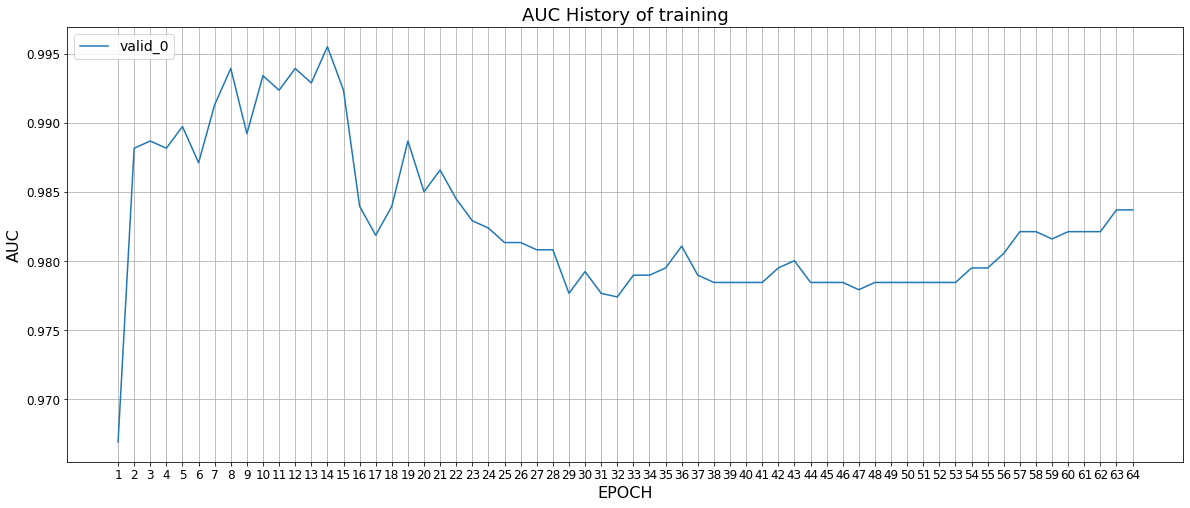

In [63]:
def plot_history(evals_result):
    for metric in ['auc']:
        plt.figure(figsize=(20,8))
        
        for key in evals_result.keys():
            history_len = len(evals_result.get(key)[metric])
            history = evals_result.get(key)[metric]
            x_axis = np.arange(1, history_len + 1)
            plt.plot(x_axis, history, label=key)
        
        x_ticks = list(filter(lambda e: (e % (history_len // 100 * 10) == 0) or e == 1, x_axis))
        plt.xticks(x_ticks, fontsize=12)
        plt.yticks(fontsize=12)

        plt.title(f'{metric.upper()} History of training', fontsize=18);
        plt.xlabel('EPOCH', fontsize=16)
        plt.ylabel(metric.upper(), fontsize=16)
        
        if metric in ['auc']:
            plt.legend(loc='upper left', fontsize=14)
        else:
            plt.legend(loc='upper right', fontsize=14)
        plt.grid()
        plt.show()

plot_history(evals_result)

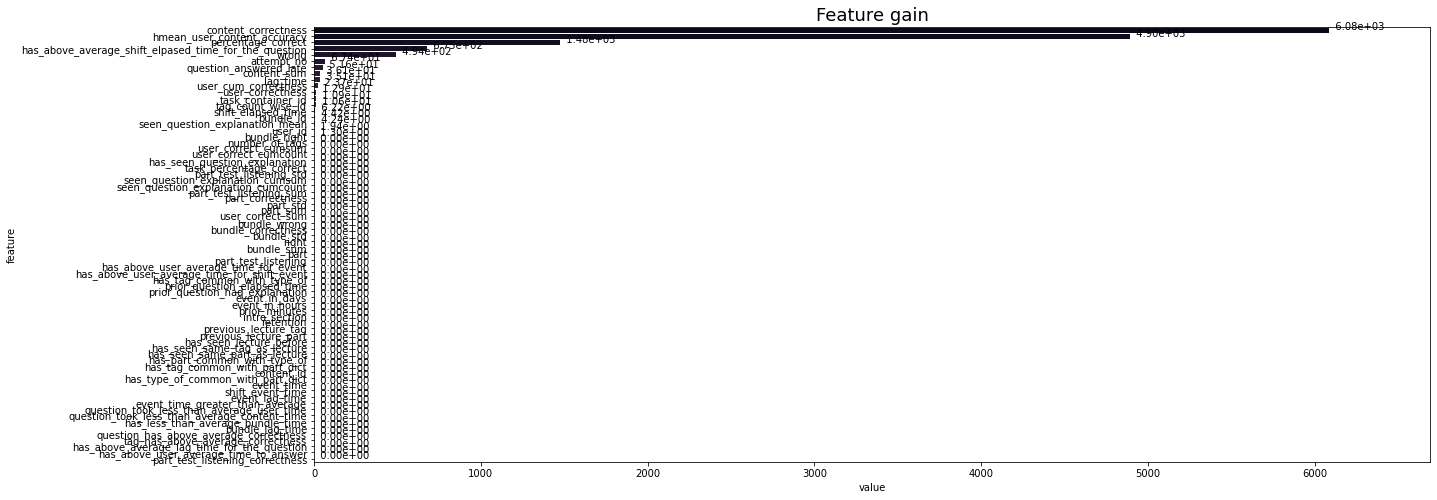

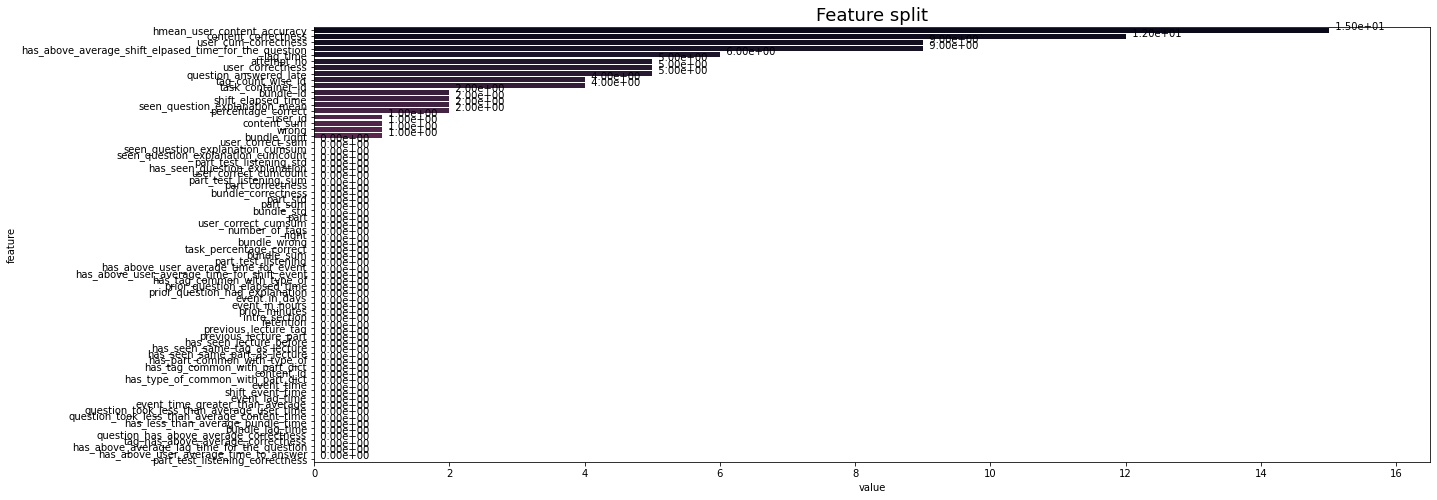

In [64]:
# plot the feature importance in terms of gain and split
def show_feature_importances(model, importance_type, max_num_features=10**10):
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = features
    feature_importances['value'] = pd.DataFrame(model.feature_importance(importance_type))
    feature_importances = feature_importances.sort_values(by='value', ascending=False) # sort feature importance
    feature_importances.to_csv(f'feature_importances_{importance_type}.csv') # write feature importance to csv
    feature_importances = feature_importances[:max_num_features] # only show max_num_features
    
    plt.figure(figsize=(20, 8))
    plt.xlim([0, feature_importances.value.max()*1.1])
    plt.title(f'Feature {importance_type}', fontsize=18);
    sns.barplot(data=feature_importances, x='value', y='feature', palette='rocket');
    for idx, v in enumerate(feature_importances.value):
        plt.text(v, idx, "  {:.2e}".format(v))

show_feature_importances(model, 'gain')
show_feature_importances(model, 'split')

In [65]:
# show tree and save as png
def save_tree_diagraph(model):
    tree_digraph = lgb.create_tree_digraph(model, show_info=['split_gain', 'internal_count'])

    tree_png = svg2png(tree_digraph._repr_svg_(), output_width=3840)
    tree_png = Image.open(BytesIO(tree_png))

    tree_png.save('create_tree_digraph.png')

    display(tree_png)
    
# save_tree_diagraph(model)

In [66]:
# remove train and validation data to free memory before prediction phase
del train_data
gc.collect()

50236

### Test set

In [67]:
class Iter_Valid(object):
    def __init__(self, df, max_user=1000):
        df = df.reset_index(drop=True)
        self.df = df
        self.user_answer = df['user_answer'].astype(str).values
        self.answered_correctly = df['answered_correctly'].astype(str).values
        df['prior_group_responses'] = "[]"
        df['prior_group_answers_correct'] = "[]"
        self.sample_df = df[df['content_type_id'] == 0][['row_id']]
        self.sample_df['answered_correctly'] = 0
        self.len = len(df)
        self.user_id = df.user_id.values
        self.task_container_id = df.task_container_id.values
        self.content_type_id = df.content_type_id.values
        self.max_user = max_user
        self.current = 0
        self.pre_user_answer_list = []
        self.pre_answered_correctly_list = []

    def __iter__(self):
        return self
    
    def fix_df(self, user_answer_list, answered_correctly_list, pre_start):
        df= self.df[pre_start:self.current].copy()
        sample_df = self.sample_df[pre_start:self.current].copy()
        df.loc[pre_start,'prior_group_responses'] = '[' + ",".join(self.pre_user_answer_list) + ']'
        df.loc[pre_start,'prior_group_answers_correct'] = '[' + ",".join(self.pre_answered_correctly_list) + ']'
        self.pre_user_answer_list = user_answer_list
        self.pre_answered_correctly_list = answered_correctly_list
        return df, sample_df

    def __next__(self):
        added_user = set()
        pre_start = self.current
        pre_added_user = -1
        pre_task_container_id = -1

        user_answer_list = []
        answered_correctly_list = []
        while self.current < self.len:
            crr_user_id = self.user_id[self.current]
            crr_task_container_id = self.task_container_id[self.current]
            crr_content_type_id = self.content_type_id[self.current]
            if crr_content_type_id == 1:
                # no more than one task_container_id of "questions" from any single user
                # so we only care for content_type_id == 0 to break loop
                user_answer_list.append(self.user_answer[self.current])
                answered_correctly_list.append(self.answered_correctly[self.current])
                self.current += 1
                continue
            if crr_user_id in added_user and ((crr_user_id != pre_added_user) or (crr_task_container_id != pre_task_container_id)):
                # known user(not prev user or differnt task container)
                return self.fix_df(user_answer_list, answered_correctly_list, pre_start)
            if len(added_user) == self.max_user:
                if  crr_user_id == pre_added_user and crr_task_container_id == pre_task_container_id:
                    user_answer_list.append(self.user_answer[self.current])
                    answered_correctly_list.append(self.answered_correctly[self.current])
                    self.current += 1
                    continue
                else:
                    return self.fix_df(user_answer_list, answered_correctly_list, pre_start)
            added_user.add(crr_user_id)
            pre_added_user = crr_user_id
            pre_task_container_id = crr_task_container_id
            user_answer_list.append(self.user_answer[self.current])
            answered_correctly_list.append(self.answered_correctly[self.current])
            self.current += 1
        if pre_start < self.current:
            return self.fix_df(user_answer_list, answered_correctly_list, pre_start)
        else:
            raise StopIteration()

### prediction

In [68]:
print('prediction started')

def set_predict(df):
    predicted.append(df)

if KAGGLE:
    iter_test = env.iter_test()
    set_predict = env.predict
else:
    target_df = target_df.sample(frac=1).reset_index(drop=True)
    iter_test = Iter_Valid(target_df, max_user=1000)
    predicted = []

prediction started


In [69]:
def sort_rows_with_respect_to_input(df, sorter):
    # Create the dictionary that defines the order for sorting
    sorterIndex = dict(zip(sorter, range(len(sorter))))

    # Generate a rank column that will be used to sort
    # the dataframe numerically
    df['row_id_rank'] = df['row_id'].map(sorterIndex)

    # Here is the result asked with the lexicographic sort
    # Result may be hard to analyze, so a second sorting is
    # proposed next
    ## NOTE: 
    ## Newer versions of pandas use 'sort_values' instead of 'sort'
    df.sort_values(['row_id_rank'], inplace = True)
    df.drop('row_id_rank', 1, inplace = True)
    print(df)
    return df

In [70]:
train_df_copy = train_df.copy()
# train_df = train_df_copy

NameError: name 'train_df_copy' is not defined

In [ ]:
train_df.has_seen_question_explanation = train_df.has_seen_question_explanation.fillna(False).astype(np.bool)

required_columns = ['user_id', 'answered_correctly']
user_cum_correctness_dict, user_correct_cumsum_dict, user_correct_cumcount_dict = get_cum_sum_std_correctness_dict(train_df[required_columns], required_columns[0], required_columns[1])

required_columns = ['user_id', 'has_seen_question_explanation']
has_seen_ques_cum_correctness_dict, has_seen_ques_correct_cumsum_dict, has_seen_ques_correct_cumcount_dict = get_cum_sum_std_correctness_dict(train_df[required_columns], required_columns[0], required_columns[1])

required_columns = ['user_id', 'answered_correctly']
user_sum_dict, user_var_dict, user_count_dict, user_correctness_dict = get_sum_std_correctness_agg_dict(train_df[required_columns], required_columns[0], required_columns[1])

required_columns = ['content_id', 'answered_correctly']
content_sum_dict, content_var_dict, content_count_dict, content_correctness_dict = get_sum_std_correctness_agg_dict(train_df[required_columns], required_columns[0], required_columns[1])

required_columns = ['bundle_id', 'answered_correctly']
bundle_sum_dict, bundle_var_dict, bundle_count_dict, bundle_correctness_dict = get_sum_std_correctness_agg_dict(train_df[required_columns], required_columns[0], required_columns[1])

required_columns = ['part', 'answered_correctly']
part_sum_dict, part_var_dict, part_count_dict, part_correctness_dict = get_sum_std_correctness_agg_dict(train_df[required_columns], required_columns[0], required_columns[1])

required_columns = ['part_test_listening', 'answered_correctly']
part_test_listening_sum_dict, part_test_listening_var_dict, part_test_listening_count_dict, part_test_listening_correctness_dict = get_sum_std_correctness_agg_dict(train_df[required_columns], required_columns[0], required_columns[1])

feature_generating_rows = [
    "timestamp",
    "predict",
    "user_id",
    "content_id",
    "content_type_id",
    "task_container_id",
    "prior_question_elapsed_time",
    "prior_question_had_explanation",
    "shift_elapsed_time",
    "shift_event_time",
    "event_time",
    "bundle_id",
    "part",
    "part_test_listening"
]

sort_ids = []
train_df_row_ids = []
pbar = tqdm(total=2500000, position=0, leave=True)

predicted_df = None
train_df['predict'] = False
# if not test_df.empty:
# for index, (_, test_df) in enumerate(iter_test):
for index, (test_df, _) in enumerate(iter_test):
# test_df, _ = next(iter_test)
# if not test_df.empty:
    if index != 0:
        # Do the operation for populating the values for the question answers

        answered_correctly = eval(test_df['prior_group_answers_correct'].iloc[0])
        previous_test_df = previous_test_df.set_index('prediction_row_id')
        for row_id, answer in list(zip(train_df_row_ids, answered_correctly)):
            previous_test_df.at[row_id, 'answered_correctly'] = answer
            previous_test_df.at[row_id, 'predict'] = False
            previous_test_df.at[row_id, 'row_id'] = row_id

        previous_test_df.reset_index(drop=True, inplace=True)
        if predicted_df is not None:
            predicted_df.append(previous_test_df)
        else:
            predicted_df = previous_test_df.copy()
        # train_df.loc[must_predict_users_filter & (train_df.content_type_id == 0), previous_test_df.columns] = previous_test_df

    train_df_row_ids = list(test_df['row_id'].values)
    sort_ids.extend(train_df_row_ids)

    test_df.rename(columns={'row_id': 'prediction_row_id'}, inplace=True)
    test_df.drop(['prior_group_answers_correct', 'prior_group_responses'], axis=1, inplace=True)
    test_df['predict'] = True
    test_df_questions_only_filter = (test_df.content_type_id == 0)
    temp_df = test_df[test_df_questions_only_filter].join(questions_df.set_index("question_id"), 'content_id', how='left')
    test_df.loc[test_df_questions_only_filter, temp_df.columns] = temp_df
    test_df_users = test_df['user_id'].unique()

    del temp_df

    must_predict_users_filter = (train_df['user_id'].isin(test_df_users))
    if predicted_df is not None:
        predicted_users_filter = (predicted_df['user_id'].isin(test_df_users))
        concat_dfs = [train_df[must_predict_users_filter], predicted_df[predicted_users_filter], test_df]
    else:
        concat_dfs = [train_df[must_predict_users_filter], test_df]
        
    predicting_users_df = pd.concat(concat_dfs)
    predicting_users_df.reset_index(drop=True, inplace=True)
    predicting_users_df.sort_values(['user_id', 'timestamp'], inplace=True)

    predict_filter = (predicting_users_df['predict'] == True)
    predicting_users_rows_only_df = predicting_users_df[predict_filter]

    predicting_users_questions_only_filter = (predicting_users_df['content_type_id'] == 0)
    check_answered_correctly_filter = (predicting_users_df['answered_correctly'] == 1)

    # ##### 4. Now lets find out the lag time
    group_by_required_fields = ['user_id', 'timestamp', 'prior_question_elapsed_time', 'prior_question_had_explanation']
    prediction_users_grouped_by_df = predicting_users_df.loc[predicting_users_questions_only_filter, group_by_required_fields].groupby('user_id')

    group_by_answered_correctly_fields = ['shift_elapsed_time', 'user_id', 'event_time', 'shift_event_time']
    prediction_users_answered_correctly_grouped_by_df = predicting_users_df.loc[check_answered_correctly_filter, group_by_answered_correctly_fields].groupby('user_id')

    content_id_group_by_required_fields = ['prior_question_elapsed_time', 'content_id']
    prediction_content_grouped_by_df = predicting_users_df.loc[predicting_users_questions_only_filter, content_id_group_by_required_fields].groupby(["content_id"])

    predicting_users_df.loc[predicting_users_questions_only_filter, ['event_time', 'shift_event_time', 'shift_elapsed_time', 'has_seen_question_explanation', 'event_lag_time']] = list(zip(*get_shift_values(prediction_users_grouped_by_df, groupby=False)))
    predicting_users_df.has_seen_question_explanation = predicting_users_df.has_seen_question_explanation.fillna(False).astype(np.bool)

    # check average user answering time
    # check average question answering time
    user_average_time_to_elapsed_dict = prediction_users_grouped_by_df.prior_question_elapsed_time.mean().to_dict()
    average_question_prior_question_elapsed_time_dict = prediction_content_grouped_by_df.prior_question_elapsed_time.mean().to_dict()

    elapsed_time_mean_dict = prediction_users_answered_correctly_grouped_by_df.shift_elapsed_time.mean().to_dict()
    event_time_mean_dict = prediction_users_answered_correctly_grouped_by_df.event_time.mean().to_dict()
    shift_event_time_mean_dict = prediction_users_answered_correctly_grouped_by_df.shift_event_time.mean().to_dict()

    event_in_days = []
    event_in_hours = []
    prior_minutes = []
    intro_sections = []
    retention = []
    previous_lecture_tag = []
    previous_lecture_part = []
    has_seen_lecture_before = []
    has_seen_same_tag_as_lecture = []
    has_seen_same_part_as_lecture = []
    has_part_common_with_type_of = []
    has_tag_common_with_type_of = []
    has_tag_common_with_part_dict = []
    has_type_of_common_with_part_dict = []
    lag_time = []
    bundle_lag_time = []
    question_answered_late = []
    event_time_greater_than_average = []
    question_took_less_than_average_user_time = []
    question_took_less_than_average_content_time = []
    has_less_than_average_bundle_time = []
    question_has_above_average_correctness = []
    tag_has_above_average_correctness = []
    has_above_average_lag_time_for_the_question = []
    has_above_average_shift_elpased_time_for_the_question = []
    has_above_user_average_time_to_answer = []
    has_above_user_average_time_for_event = []
    has_above_user_average_time_for_shift_event = []

    user_cum_correctness = []
    user_correct_cumsum = []
    user_correct_cumcount = []

    seen_question_explanation_mean = []
    seen_question_explanation_cumsum = []
    seen_question_explanation_cumcount = []

    user_correct_sum = []
    user_correct_std = []
    user_correctness = []

    content_sum = []
    content_std = []
    content_correctness = []
    bundle_sum = []
    bundle_std = []
    bundle_correctness = []
    part_sum = []
    part_std = []
    part_correctness = []
    part_test_listening_sum = []
    part_test_listening_std = []
    part_test_listening_correctness = []

    hmean_user_content_accuracy = []
    for row in predicting_users_df[feature_generating_rows].itertuples():
        if row.predict:
            # ### Set User specific features
            # ##### 1. Get timestamp as hours and minutes
            event_time_split = get_timestamp_in_parts(row)
            event_in_days.append(event_time_split[0])
            event_in_hours.append(event_time_split[1])

            prior_minutes.append(get_prior_elasped_time_in_parts(row))

            # ##### 2. Find the intro rows.
            if row.timestamp == 0 or row.task_container_id == 0 or row.content_id in intro_section_values:
                intro_sections.append(True)
            else:
                intro_sections.append(False)

        # ##### 3. The actions after the lectures should be tagged with something.
        time_related_feature_values = running_retention(row)
        retention.append(time_related_feature_values[0])
        previous_lecture_tag.append(time_related_feature_values[1])
        previous_lecture_part.append(time_related_feature_values[2])
        has_seen_lecture_before.append(time_related_feature_values[3])
        has_seen_same_tag_as_lecture.append(time_related_feature_values[4])
        has_seen_same_part_as_lecture.append(time_related_feature_values[5])
        has_part_common_with_type_of.append(time_related_feature_values[6])
        has_tag_common_with_type_of.append(time_related_feature_values[7])
        has_tag_common_with_part_dict.append(time_related_feature_values[8])
        has_type_of_common_with_part_dict.append(time_related_feature_values[9])

        if row.content_type_id == 0:
            lag_time_value = get_prior_elapsed_time_difference(row.content_id, row.shift_elapsed_time)
            lag_time.append(lag_time_value)
            bundle_lag_time.append(get_bundle_lag_time(row))
            question_answered_late.append(has_elapsed_time_greater_than_average_time(row.content_id, row.shift_elapsed_time))
            event_time_greater_than_average.append(has_event_time_greater_than_average(row.content_id, row.shift_event_time))
            question_took_less_than_average_user_time.append(row.prior_question_elapsed_time < user_average_time_to_elapsed_dict.get(row.user_id, 0))
            question_took_less_than_average_content_time.append(row.prior_question_elapsed_time < average_question_prior_question_elapsed_time_dict.get(row.user_id, 0))
            has_less_than_average_bundle_time.append(row.shift_elapsed_time < bundle_time_relation_dict.get(row.content_id, {"average_time": 0})['average_time'])
            question_has_above_average_correctness.append(is_question_above_average_answering(row))
            tag_has_above_average_correctness.append(is_all_tags_above_average_answering(row))
            has_above_average_lag_time_for_the_question.append(lag_time_value > lag_time_answered_correctly_mean_dict.get(row.content_id, 0))
            has_above_average_shift_elpased_time_for_the_question.append(row.shift_elapsed_time > shift_elapsed_time_answered_correctly_mean_dict.get(row.content_id, 0))

            has_above_user_average_time_to_answer.append(elapsed_time_mean_dict.get(row.user_id, 0) <= row.shift_elapsed_time)
            has_above_user_average_time_for_event.append(event_time_mean_dict.get(row.user_id, 0) <= row.event_time)
            has_above_user_average_time_for_shift_event.append(shift_event_time_mean_dict.get(row.user_id, 0) <= row.shift_event_time)

            user_cum_correctness.append(user_cum_correctness_dict.get(row.user_id, 0))
            user_correct_cumsum.append(user_correct_cumsum_dict.get(row.user_id, 0))
            user_correct_cumcount.append(user_correct_cumcount_dict.get(row.user_id, 0))

            seen_question_explanation_mean.append(has_seen_ques_cum_correctness_dict.get(row.content_id, 0))
            seen_question_explanation_cumsum.append(has_seen_ques_correct_cumsum_dict.get(row.content_id, 0))
            seen_question_explanation_cumcount.append(has_seen_ques_correct_cumcount_dict.get(row.content_id, 0))

            user_correct_sum.append(user_sum_dict.get(row.user_id, 0))
            user_correct_std.append(user_var_dict.get(row.user_id, 0))
            user_correctness.append(user_count_dict.get(row.user_id, 0))

        content_sum.append(content_sum_dict.get(row.content_id, 0))
        content_std.append(content_var_dict.get(row.content_id, 0))
        content_correctness.append(content_correctness_dict.get(row.content_id, 0))
        bundle_sum.append(bundle_sum_dict.get(row.bundle_id, 0))
        bundle_std.append(bundle_var_dict.get(row.bundle_id, 0))
        bundle_correctness.append(bundle_correctness_dict.get(row.bundle_id, 0))
        part_sum.append(part_sum_dict.get(row.part, 0))
        part_std.append(part_var_dict.get(row.part, 0))
        part_correctness.append(part_correctness_dict.get(row.part, 0))
        part_test_listening_sum.append(part_test_listening_sum_dict.get(row.part_test_listening, 0))
        part_test_listening_std.append(part_test_listening_var_dict.get(row.part_test_listening, 0))
        part_test_listening_correctness.append(part_test_listening_correctness_dict.get(row.part_test_listening, 0))

        if (user_count_dict.get(row.user_id, 0) + content_correctness_dict.get(row.content_id, 0)) != 0:
            hmean_user_content_accuracy.append(2 * (
                (user_count_dict.get(row.user_id, 0) * content_correctness_dict.get(row.content_id, 0)) /
                (user_count_dict.get(row.user_id, 0) + content_correctness_dict.get(row.content_id, 0))
            ))
        else:
            hmean_user_content_accuracy.append(0)
    # ### Prepare first group test set with train_df
    # ##### 1. Get timestamp as hours and minutes

    predicting_users_rows_only_df[
        [
            'event_in_days',
            'event_in_hours',
            'prior_minutes',
            'intro_section'
        ]
    ] = list(zip(event_in_days, event_in_hours, prior_minutes, intro_sections))

    # ======================================
    predicting_users_df.loc[predict_filter] = predicting_users_rows_only_df
    del predicting_users_rows_only_df
    # ======================================
    # ##### 3. The actions after the lectures should be tagged with something.
    predicting_users_df[
        [
            "retention",
            "previous_lecture_tag",
            "previous_lecture_part",
            "has_seen_lecture_before",
            "has_seen_same_tag_as_lecture",
            "has_seen_same_part_as_lecture",
            "has_part_common_with_type_of",
            "has_tag_common_with_type_of",
            "has_tag_common_with_part_dict",
            "has_type_of_common_with_part_dict",
        ]
    ] = list(zip(
        retention,
        previous_lecture_tag,
        previous_lecture_part,
        has_seen_lecture_before,
        has_seen_same_tag_as_lecture,
        has_seen_same_part_as_lecture,
        has_part_common_with_type_of,
        has_tag_common_with_type_of,
        has_tag_common_with_part_dict,
        has_type_of_common_with_part_dict,
    ))

    # Make train df only question and not lectures
    # ======================================
    # train_df_elapsed_time_groupby = predicting_users_df[['content_id', 'shift_elapsed_time']].groupby(['content_id']).shift_elapsed_time
    # individual_question_min_time_dict = train_df_elapsed_time_groupby.min().to_dict()
    # individual_question_mean_time_dict = train_df_elapsed_time_groupby.mean().to_dict()

    # average_question_timestamp_difference_dict = train_df[(train_df['shift_event_time'] < 3600000)][['content_id', 'shift_event_time']].groupby('content_id').shift_event_time.mean().to_dict()

    # del train_df_elapsed_time_groupby
    # ======================================
    predicting_users_df.loc[
        predicting_users_questions_only_filter,
        [
            'lag_time',
            'bundle_lag_time',
            'question_answered_late',
            'event_time_greater_than_average',
            'question_took_less_than_average_user_time',
            'question_took_less_than_average_content_time',
            'has_less_than_average_bundle_time',
            'question_has_above_average_correctness',
            'tag_has_above_average_correctness',
            'has_above_average_lag_time_for_the_question',
            'has_above_average_shift_elpased_time_for_the_question',
            'has_above_user_average_time_to_answer',
            'has_above_user_average_time_for_event',
            'has_above_user_average_time_for_shift_event',
            'user_cum_correctness',
            'user_correct_cumsum',
            'user_correct_cumcount',
            'seen_question_explanation_mean',
            'seen_question_explanation_cumsum',
            'seen_question_explanation_cumcount',
            'user_correct_sum',
            'user_correct_std',
            'user_correctness',
            'content_sum',
            'content_std',
            'content_correctness',
            'bundle_sum',
            'bundle_std',
            'bundle_correctness',
            'part_sum',
            'part_std',
            'part_correctness',
            'part_test_listening_sum',
            'part_test_listening_std',
            'part_test_listening_correctness',
            'hmean_user_content_accuracy'
        ]
    ] = list(zip(
        lag_time,
        bundle_lag_time,
        question_answered_late,
        event_time_greater_than_average,
        question_took_less_than_average_user_time,
        question_took_less_than_average_content_time,
        has_less_than_average_bundle_time,
        question_has_above_average_correctness,
        tag_has_above_average_correctness,
        has_above_average_lag_time_for_the_question,
        has_above_average_shift_elpased_time_for_the_question,
        has_above_user_average_time_to_answer,
        has_above_user_average_time_for_event,
        has_above_user_average_time_for_shift_event,
        user_cum_correctness,
        user_correct_cumsum,
        user_correct_cumcount,
        seen_question_explanation_mean,
        seen_question_explanation_cumsum,
        seen_question_explanation_cumcount,
        user_correct_sum,
        user_correct_std,
        user_correctness,
        content_sum,
        content_std,
        content_correctness,
        bundle_sum,
        bundle_std,
        bundle_correctness,
        part_sum,
        part_std,
        part_correctness,
        part_test_listening_sum,
        part_test_listening_std,
        part_test_listening_correctness,
        hmean_user_content_accuracy
    ))

    # ##### 7. The prior time mean for each user should be averaged to check if the user too more than usual
    # TODO: Do the following by setting the time rather than setting the flag
    # BUG: The comparison seems to be wrong 
    
    # ======================================
    
    # ##### 10. The attempt feature
    predicting_users_df["attempt_no"] = 1
    predicting_users_df.attempt_no = predicting_users_df.attempt_no.astype('int8')
    predicting_users_df["attempt_no"] = predicting_users_df[["user_id", "content_id", "attempt_no"]].groupby(["user_id", "content_id"])["attempt_no"].cumsum()


    # ======================================


    predict_df = predicting_users_df[predicting_users_questions_only_filter & predict_filter]

    previous_test_df = predicting_users_df.copy()
    # del predicting_users_df
    boolean_columns = [
        "prior_question_had_explanation",
        "intro_section",
        "has_seen_lecture_before",
        "has_seen_same_tag_as_lecture",
        "has_seen_same_part_as_lecture",
        "has_part_common_with_type_of",
        "has_tag_common_with_type_of",
        "has_tag_common_with_part_dict",
        "has_type_of_common_with_part_dict",
        "question_answered_late",
        "event_time_greater_than_average",
        "question_took_less_than_average_user_time",
        "question_took_less_than_average_content_time",
        "has_less_than_average_bundle_time",
        "question_has_above_average_correctness",
        "tag_has_above_average_correctness",
        "has_above_average_lag_time_for_the_question",
        "has_above_average_shift_elpased_time_for_the_question",
        "has_above_user_average_time_to_answer",
        "has_above_user_average_time_for_event",
        "has_above_user_average_time_for_shift_event",
        "part_test_listening",
        "has_seen_question_explanation"
    ]

    predict_df[boolean_columns] = predict_df[boolean_columns].fillna(False).astype(np.bool)
    prediction_row_ids = predict_df.prediction_row_id.values
    predictions_list  = model.predict(predict_df[features])

    predictions_df = pd.DataFrame({'row_id': prediction_row_ids, 'answered_correctly': predictions_list})
    set_predict(predictions_df)

    del predictions_df
    del predict_df
    import gc
    gc.collect()
    pbar.update(len(predictions_list))
print('prediction done')


In [ ]:
train_df.loc[train_df.prediction_row_id.isin(sort_ids)]

In [ ]:
len(sort_ids)

In [ ]:
if KAGGLE:
    y_true = target_df[target_df.content_type_id == 0].answered_correctly
    y_pred = pd.concat(predicted).answered_correctly
    print('validation auc:', roc_auc_score(y_true, y_pred))


In [ ]:
dtypes = {
    'row_id': 'int64',
    'answered_correctly': 'float32'
}
submission_df = pd.read_csv('submission.csv', dtype=dtypes)
submission_df = sort_rows_with_respect_to_input(submission_df, sort_ids)
submission_df.to_csv('submission.csv', index=False)

In [ ]:
# code you want to evaluate
elapsed = timeit.default_timer() - start_time
import datetime
print(str(datetime.timedelta(seconds=elapsed)))

- Validation set needs to be done
- The lecture thing should be done
- The luckyness which we saw needs to be checked
- The pending items in the feature set also needed to be done